In [2]:
from typing import List, Type, Dict, Any

import numpy as np
import torch

from types import SimpleNamespace
from torch.optim import SGD
from torch.optim import Adagrad as torch_adagrad
from torch.optim import RMSprop as torch_rmsprop
from torch.optim import Adadelta as torch_adadelta
from torch.optim import Adam as torch_adam
import matplotlib.pyplot as plt

In [3]:
def optim_f(w: torch.Tensor) -> torch.Tensor:
    x = torch.tensor([0.2, 2], dtype=torch.float)
    return torch.sum(x * w ** 2)


def optim_g(w: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    x = torch.tensor([0.2, 2], dtype=torch.float)
    return torch.sum(x * w + b)


opt_checker_1 = SimpleNamespace(
    f=optim_f, params=[torch.tensor([-6, 2], dtype=torch.float, requires_grad=True)]
)
opt_checker_2 = SimpleNamespace(
    f=optim_g,
    params=[
        torch.tensor([-6, 2], dtype=torch.float, requires_grad=True),
        torch.tensor([1, -1], dtype=torch.float, requires_grad=True),
    ],
)

test_params = {
    "Momentum": {
        "torch_cls": SGD,
        "torch_params": {"lr": 0.1, "momentum": 0.9},
        "params": {"learning_rate": 0.1, "gamma": 0.9},
    },
    "Adagrad": {
        "torch_cls": torch_adagrad,
        "torch_params": {"lr": 0.5, "eps": 1e-8},
        "params": {"learning_rate": 0.5, "epsilon": 1e-8},
    },
    "RMSProp": {
        "torch_cls": torch_rmsprop,
        "torch_params": {
            "lr": 0.5,
            "alpha": 0.9,
            "eps": 1e-08,
        },
        "params": {"learning_rate": 0.5, "gamma": 0.9, "epsilon": 1e-8},
    },
    "Adadelta": {
        "torch_cls": torch_adadelta,
        "torch_params": {"rho": 0.9, "eps": 1e-1},
        "params": {"gamma": 0.9, "epsilon": 1e-1},
    },
    "Adam": {
        "torch_cls": torch_adam,
        "torch_params": {"lr": 0.5, "betas": (0.9, 0.999), "eps": 1e-08},
        "params": {"learning_rate": 0.5, "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-8},
    },
}


def test_optimizer(optim_cls: Type, num_steps: int = 10) -> None:
    test_dict = test_params[optim_cls.__name__]

    for ns in [opt_checker_1, opt_checker_2]:
        torch_params = [p.clone().detach().requires_grad_(True) for p in ns.params]
        torch_opt = test_dict["torch_cls"](torch_params, **test_dict["torch_params"])
        for _ in range(num_steps):
            torch_opt.zero_grad()

            loss = ns.f(*torch_params)
            loss.backward()
            torch_opt.step()

        params = [p.clone().detach().requires_grad_(True) for p in ns.params]
        opt = optim_cls(params, **test_dict["params"])

        for _ in range(num_steps):
            opt.zero_grad()

            loss = ns.f(*params)
            loss.backward()
            opt.step()

        for p, tp in zip(params, torch_params):
            assert torch.allclose(p, tp)

def visualize_optimizer(
    optim: torch.optim.Optimizer, n_steps: int, title: str | None = None, **params: Dict[str, Any]
) -> None:
    def f(w: torch.Tensor) -> torch.Tensor:
        x = torch.tensor([0.2, 2], dtype=torch.float)
        return torch.sum(x * w**2)

    w = torch.tensor([-6, 2], dtype=torch.float, requires_grad=True)

    optimizer = optim([w], **params)

    history = [w.clone().detach().numpy()]

    for i in range(n_steps):
        optimizer.zero_grad()

        loss = f(w)
        loss.backward()
        optimizer.step()
        history.append(w.clone().detach().numpy())

    delta = 0.01
    x = np.arange(-7.0, 7.0, delta)
    y = np.arange(-4.0, 4.0, delta)
    X, Y = np.meshgrid(x, y)

    Z = 0.2 * X**2 + 2 * Y**2

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.contour(X, Y, Z, 20)

    h = np.array(history)

    ax.plot(h[:, 0], h[:, 1], "x-")

    if title is not None:
        ax.set_title(title)

# Optymalizatory

Państwa dzisiejszym zadaniem będzie zaimplementowanie najpopularniejszych optymalizatorów stosowanych w uczeniu maszynowym.

Każda z implementowanych przez Państwa klas dziedziczy po klasie `Optimizer`, w której gotowe są już pewne funkcjonalności. Państwa zadanie to przeładowanie metody `step` (oraz naturalnie dodawanie wymaganych rzeczy do konstruktora).

Ogólne uwagi do zadań:
* **Proszę zwrócić uwagę na modyfikowanie tensorów in-place (-=) tak aby oryginalne tensory zostały zmodyfikowane.**
* Proszę zwracać uwagę przy zmienianiu parametrów w środku optimizera, tak aby faktycznie je zmieniać. Można wzorować się na poniższej implementacji `GradientDescent`.
* Kolejność wzorów w sekcjach "Update" kolejnych metod jest jednocześnie zalecaną kolejnością implementacji.

In [4]:
class Optimizer:
    """Base class for each optimizer"""

    def __init__(self, initial_params):
        # store model weights
        self.params = initial_params

    def step(self):
        """Updates the weights stored in self.params"""
        raise NotImplementedError()

    def zero_grad(self):
        """Torch accumulates gradients, so we need to clear them after every update"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()


class GradientDescent(Optimizer):
    def __init__(self, initial_params: List[torch.tensor], learning_rate):
        super().__init__(initial_params)
        self.learning_rate = learning_rate

    @torch.no_grad()
    def step(self):
        for param in self.params:
            # Please note that it's important to change the parameters in-place (-=) so the original tensors are modified
            param -= self.learning_rate * param.grad

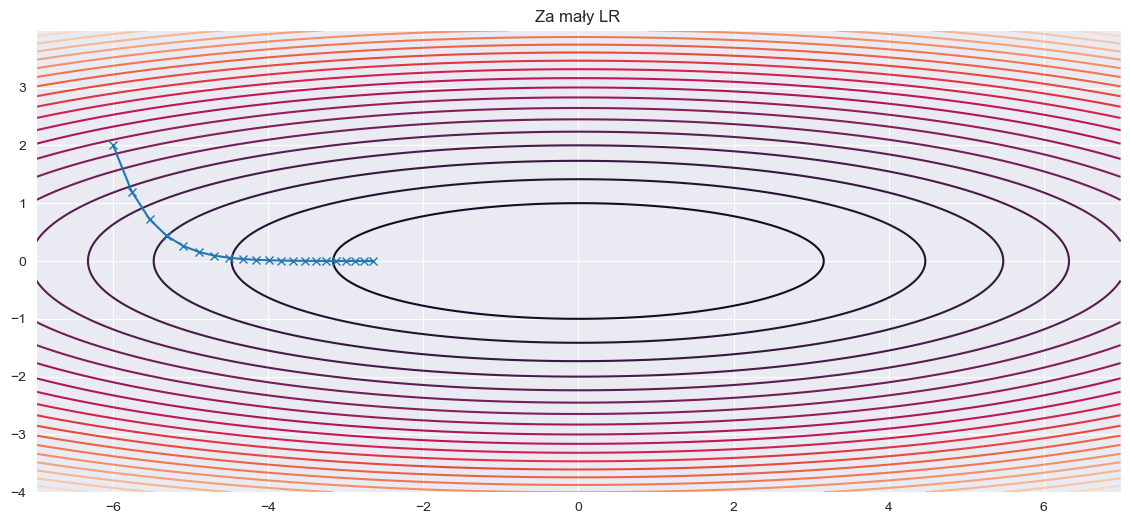

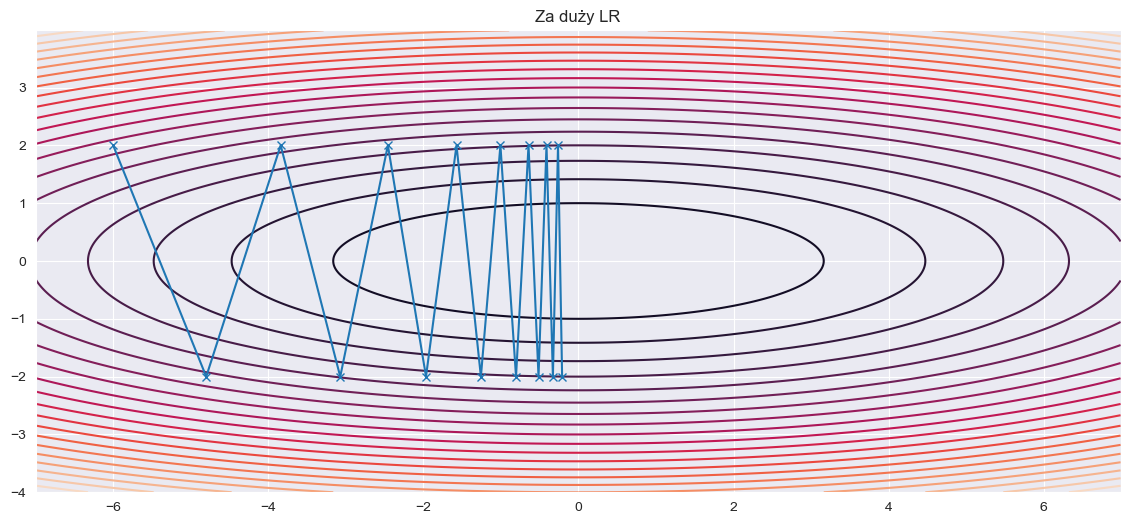

In [5]:
visualize_optimizer(GradientDescent, n_steps=20, learning_rate=0.1, title="Za mały LR")
visualize_optimizer(GradientDescent, n_steps=15, learning_rate=0.5, title="Za duży LR")

## Zad1. Momentum
Hiperparamerty:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Momentum (zawsze < 1, typowo 0.9)

### Update
Zmiany dokonywane są na podstawie wektora "pędu" (ang. *momentum*) $\Delta$, który rośnie jeżeli dokonujemy zmian w tym samym kierunku.

<font size="+2"> $$ \Delta_{t+1} = \gamma  \Delta_{t} + \eta \nabla_\theta \mathcal{L}(\theta_t) $$ </font><br>
<font size="+2"> $$ \theta_{t+1} = \theta_{t} - \Delta_{t+1} $$ </font>

#### Uwagi
* $\Delta_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.

In [6]:
class Momentum(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.deltas = [torch.zeros_like(param) for param in self.params]
        # your code here
    
    @torch.no_grad()
    def step(self):
        
        for i, param in enumerate(self.params):
            self.deltas[i] = (self.gamma * self.deltas[i]) + (self.learning_rate * param.grad)
            param -= self.deltas[i]
            

In [7]:
test_optimizer(Momentum)

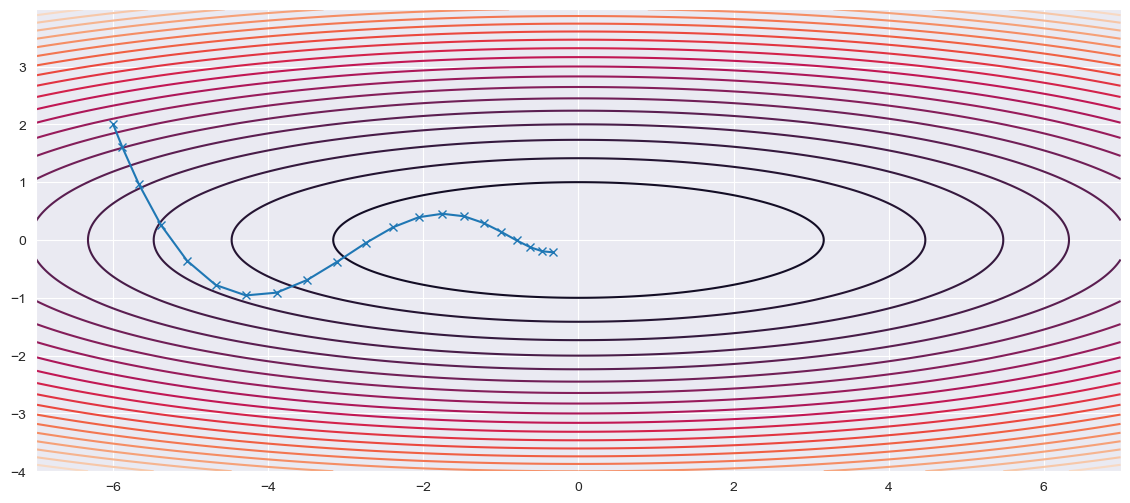

In [8]:
visualize_optimizer(Momentum, n_steps=20, learning_rate=0.05, gamma=0.8)

## Zad2. Adagrad
Hiperparamerty:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

### Update
W każdym kroku adaptujemy stałą uczenia $\eta$ dla każdego z wymiarów wag na podstawie sumy kwadratów dotychczasowych gradientów.

<font size="+2"> $$ \displaystyle  G_t = \sum_{i = 1}^{t} \big(\nabla_\theta \mathcal{L}(\theta_i)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



<font size="+0"> gdzie $G_t$ to suma kwadratów gradientów $\nabla_\theta \mathcal{L}(\theta_i)^2$ dla kroków $i = 1, .., t$ </font>

##### Uwagi
* $G_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [9]:
class Adagrad(Optimizer):
    
    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.g = [torch.zeros_like(param) for param in self.params]
        # your code here
        
    @torch.no_grad()
    def step(self):
        for i, param in enumerate(self.params):
            grad = param.grad
            self.g[i] += grad ** 2
            param -= self.learning_rate * grad / torch.sqrt(self.g[i] + self.epsilon)
            
            
        # your code here
        

In [10]:
test_optimizer(Adagrad)

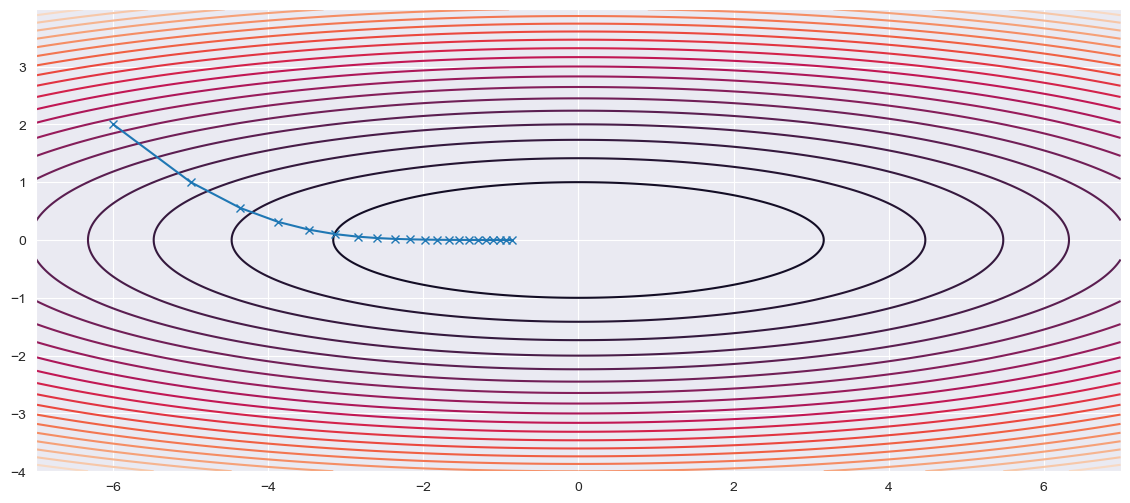

In [11]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=1.0, epsilon=1e-8)

## Zad 3. RMSProp 
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

### Update
Analogicznie dla algorytmu *Adagrad* adaptujemy stałą uczenia, lecz tym razem zamiast sumy, robimy to średnią kroczącą ze współczynnikiem $\gamma$.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



gdzie $H_t$ to średnia krocząca kwadratów gradientów $(\nabla_\theta \mathcal{L}(\theta_t))^2$ z kroków $0, 1, ..., t$ ze współczynnikiem $\gamma$.

#### Uwagi
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [12]:
class RMSProp(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.H = [torch.zeros_like(param) for param in self.params]
        
        # your code here

    @torch.no_grad()
    def step(self):
        for i, param in enumerate(self.params):
            grad = param.grad
            self.H[i] = (self.gamma * self.H[i]) + ((1 - self.gamma) * (grad ** 2))
            update_coef = self.learning_rate / (self.H[i] + self.epsilon).sqrt()
            param -= update_coef * grad 
         # your code here
            

In [13]:
test_optimizer(RMSProp)

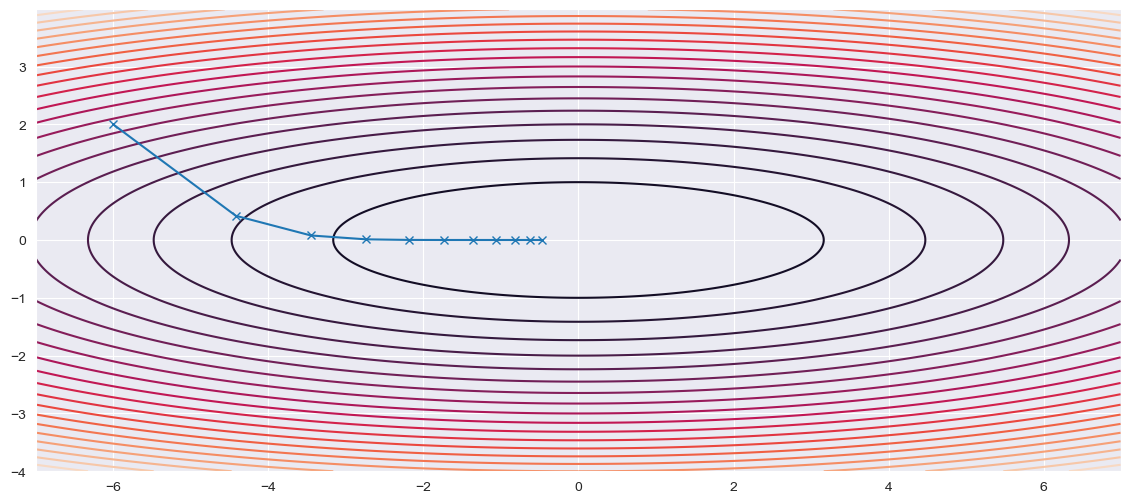

In [14]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

## Zad4. Adadelta
Hiperparametry:
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 oraz rozpoczęcia uczenia (typowo $10^{-8}$ do $10^{-2}$)

### Update
Eliminujemy stałą uczenia $\eta$ i sprawiamy, że "prędkość" poprawek jest podobna do faktycznych poprawek uzależniając krok uczenia od średniej kroczącej poprzednich poprawek.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \Delta_{t+1} = \frac{\sqrt{D_{t} + \epsilon}}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \Delta_{t+1} $$ </font>

<font size="+2"> $$ D_{t+1} = \gamma D_{t} + (1 - \gamma) \Delta_{t+1}^2 $$ </font>

#### Uwagi:
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $D_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [21]:
class Adadelta(Optimizer):
    def __init__(self, initial_params, gamma, epsilon):
        super().__init__(initial_params)
        self.gamma = gamma
        self.epsilon = epsilon
        self.H = [torch.zeros_like(param) for param in self.params]
        self.D = [torch.zeros_like(param) for param in self.params]

        # your code here
        
    @torch.no_grad()
    def step(self):
        for i, param in enumerate(self.params):
            grad = param.grad
            self.H[i] = (self.gamma * self.H[i]) + ((1 - self.gamma) * (grad ** 2))
            delta = (torch.sqrt(self.D[i] + self.epsilon) / torch.sqrt(self.H[i] + self.epsilon)) * grad
            param -= delta
            self.D[i] = (self.gamma * self.D[i]) + ((1 - self.gamma) * (delta ** 2))
            
        # your code here
        

In [22]:
test_optimizer(Adadelta)

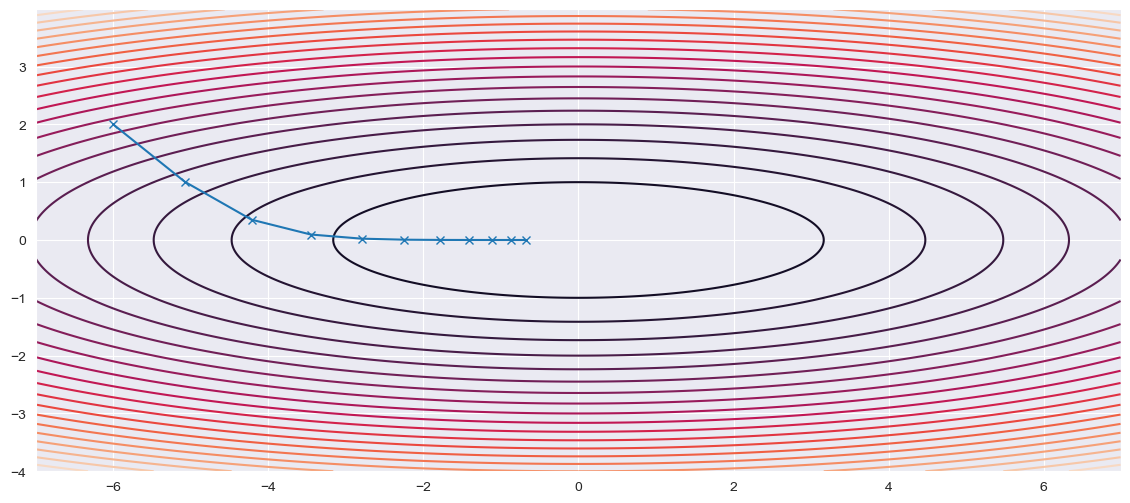

In [23]:
visualize_optimizer(Adadelta, n_steps=10, gamma=0.9, epsilon=1e-1)

## Zad 5. Adam 

Hiperparametry:
* $\eta$ - Learning Rate (typowo 0.001)
* $\beta_1$ - współczynnik średniej kroczącej pierwszego momentu (typowo 0.9)
* $\beta_2$ - współczynnik średniej kroczącej drugiego momentu (typowo 0.999)
* $\epsilon$ - zapobiega dzieleniu przez zero (typowo $10^{-8}$)

### Update
Adaptujemy gradient dwiema średnimi kroczącymi, pierwszego $m$ i drugiego $v$ momentu. Na początku uczenia te średnie są bardzo zbiasowane do 0, stąd wprowadzane są poprawka $\hat{m}$ i $\hat{v}$, im dalej w procesie uczenia, tym te poprawki wprowadzają mniejsze zmiany.  

<font size="+2"> $$ m_{t+1} = \beta_1 m_{t} + (1 - \beta_1)  \nabla_\theta \mathcal{L}(\theta_t) $$ </font>
<font size="+2"> $$ v_{t+1} = \beta_2 v_{t} + (1 - \beta_2)  \big( \nabla_\theta \mathcal{L}(\theta_t) \big)^2 $$ </font>
<br>
<font size="+2"> $$  \hat{m} = \frac{m_{t+1}}{1 - \beta_1^{(t+1)}} $$ </font><br>
<font size="+2"> $$  \hat{v} = \frac{v_{t+1}}{1 - \beta_2^{(t+1)}} $$ </font>
<br>
<font size="+2"> $$ \theta_{t+1} = \theta_t - \eta \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon} $$ </font>

#### Uwagi
* $m_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $v_0 = \mathbf{0}$, wymiar taki sam jak $\theta$. 
* $\beta_1^{(t+1)}$ oraz $\beta_2^{(t+1)}$ to potęgowania.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.


In [44]:
class Adam(Optimizer):
   
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(param) for param in self.params]
        self.v = [torch.zeros_like(param) for param in self.params]
        self.t = 1
        print(self.params[0].shape)
        
    
        # your code here
        
    @torch.no_grad()
    def step(self):
        for i, param in enumerate(self.params):
            grad = param.grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            m = self.m[i] / (1 - (self.beta1 ** self.t))
            v = self.v[i] / (1 - (self.beta2 ** self.t))
            param -= self.learning_rate * m / (torch.sqrt(v) + self.epsilon)
        self.t += 1
            
            
        
        # your code here
        

In [45]:
test_optimizer(Adam)

torch.Size([2])
torch.Size([2])


torch.Size([2])


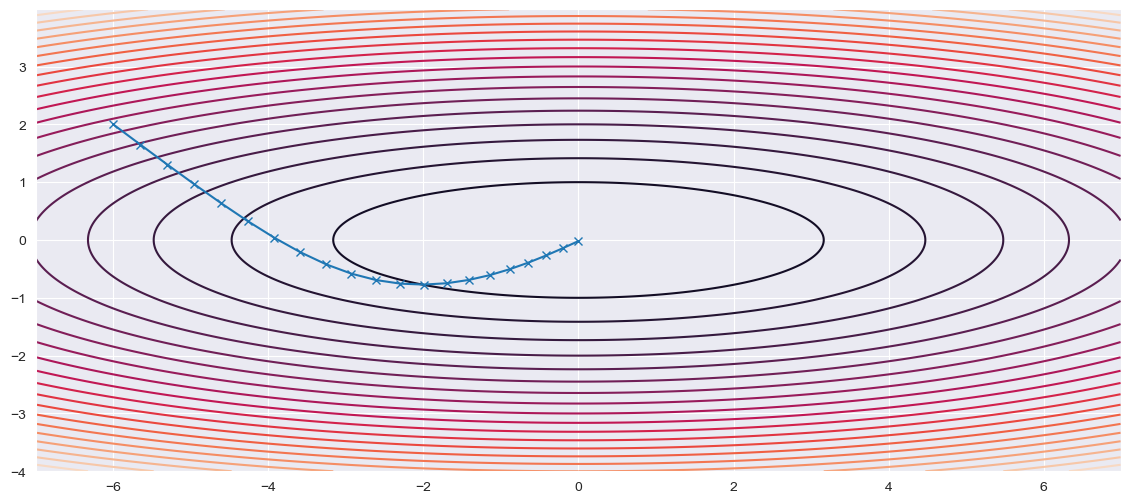

In [46]:
visualize_optimizer(Adam, n_steps=20, learning_rate=0.35, beta1=0.9, beta2=0.999, epsilon=1e-8)